# Benchmarking lung integration

Here we walkthrough applying the integration benchmarking metrics on the lung atlas example from the [scIB paper](https://www.nature.com/articles/s41592-021-01336-8).

In [16]:
import numpy as np
from anndata import AnnData
import matplotlib.pyplot as plt
import scanpy as sc
from plottable import Table

from scib_metrics.benchmark import Benchmarker
%matplotlib inline

## Load and preprocess data

In [2]:
adata = sc.read(
    "data/lung_atlas.h5ad",
    backup_url="https://figshare.com/ndownloader/files/24539942",
)

In [3]:
adata

AnnData object with n_obs × n_vars = 32472 × 15148
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor'
    layers: 'counts'

In [4]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor="cell_ranger", batch_key="batch")
sc.tl.pca(adata, n_comps=30, use_highly_variable=True)


/home/adam/miniconda3/envs/scib-metrics/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/adam/miniconda3/envs/scib-metrics/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/adam/miniconda3/envs/scib-metrics/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/adam/miniconda3/envs/scib-metrics/lib/python3.10/site-packages/scanpy/preproces

We subset to the highly variable genes so that each method has the same input.

In [5]:
adata = adata[:, adata.var.highly_variable].copy()

In [6]:
adata.obsm["Unintegrated"] = adata.obsm["X_pca"]

## Run methods

Here we run a few embedding-based methods. By focusing on embedding-based methods, we can substantially reduce the runtime of the benchmarking metrics.

In principle, graph-based integration methods can also be benchmarked on some of the metrics that have graph inputs. Future work can explore using graph convolutional networks to embed the graph and then using the embedding-based metrics.

### Scanorama

In [7]:
%%capture
import scanorama
# List of adata per batch
batch_cats = adata.obs.batch.cat.categories
adata_list = [adata[adata.obs.batch == b].copy() for b in batch_cats]
scanorama.integrate_scanpy(adata_list)

adata.obsm["Scanorama"] = np.zeros((adata.shape[0], adata_list[0].obsm["X_scanorama"].shape[1]))
for i, b in enumerate(batch_cats):
    adata.obsm["Scanorama"][adata.obs.batch == b] = adata_list[i].obsm["X_scanorama"]

### Liger

In [8]:
import pyliger
bdata = adata.copy()
# Pyliger normalizes by library size with a size factor of 1
# So here we give it the count data
bdata.X = bdata.layers["counts"]
# List of adata per batch
adata_list = [bdata[bdata.obs.batch == b].copy() for b in batch_cats]
for i, ad in enumerate(adata_list):
    ad.uns["sample_name"] = batch_cats[i]
    # Hack to make sure each method uses the same genes
    ad.uns['var_gene_idx'] = np.arange(bdata.n_vars)


liger_data = pyliger.create_liger(adata_list, remove_missing=False, make_sparse=False)
# Hack to make sure each method uses the same genes
liger_data.var_genes = bdata.var_names
pyliger.normalize(liger_data)
pyliger.scale_not_center(liger_data)
pyliger.optimize_ALS(liger_data, k=30)
pyliger.quantile_norm(liger_data)


adata.obsm["LIGER"] = np.zeros((adata.shape[0], liger_data.adata_list[0].obsm["H_norm"].shape[1]))
for i, b in enumerate(batch_cats):
    adata.obsm["LIGER"][adata.obs.batch == b] = liger_data.adata_list[i].obsm["H_norm"]

/home/adam/miniconda3/envs/scib-metrics/lib/python3.10/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
100%|██████████| 30/30 [02:36<00:00,  5.20s/it]


### Harmony

In [9]:
from harmony import harmonize
adata.obsm["Harmony"] = harmonize(adata.obsm["X_pca"], adata.obs, batch_key = "batch")

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
	Completed 9 / 10 iteration(s).
	Completed 10 / 10 iteration(s).


### scVI

In [10]:
%%capture
import scvi
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")
vae = scvi.model.SCVI(adata, gene_likelihood="nb", n_layers=2, n_latent=30)
vae.train()
adata.obsm["scVI"] = vae.get_latent_representation()

INFO:pytorch_lightning.utilities.seed:Global seed set to 0
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=246` reached.


### scANVI

In [11]:
%%capture
lvae = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata,
    labels_key="cell_type",
    unlabeled_category="Unknown",
)
lvae.train(max_epochs=20, n_samples_per_label=100)
adata.obsm["scANVI"] = lvae.get_latent_representation()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


## Perform the benchmark

In [12]:
bm = Benchmarker(
    adata,
    batch_key="batch",
    label_key="cell_type",
    embedding_obsm_keys=["Unintegrated", "Scanorama", "LIGER", "Harmony", "scVI", "scANVI"],
    n_jobs=6,
)
bm.benchmark()


Embeddings: 100%|██████████| 6/6 [02:41<00:00, 26.91s/it]


### Visualize the results

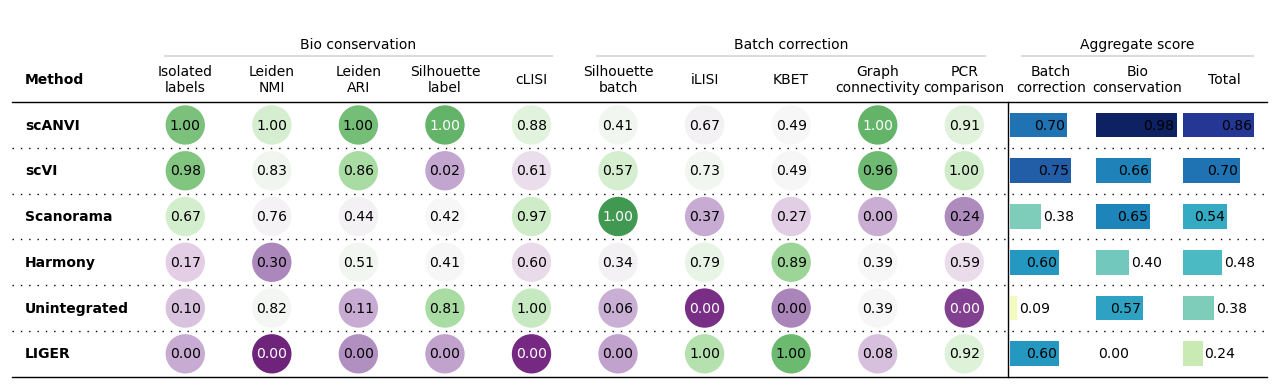

In [17]:
bm.plot_results_table()

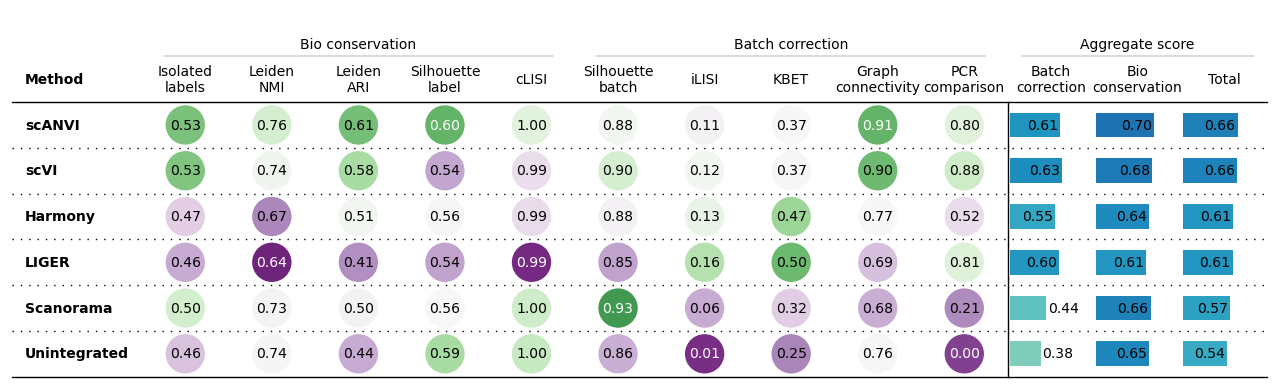

In [18]:
bm.plot_results_table(min_max_scale=False)

We can also access the underlying dataframes to print the results ourselves.

In [28]:
from rich import print
df = bm.get_results(min_max_scale=False)
print(df)

Isolated labels        Leiden NMI        Leiden ARI  \
Embedding                                                            
Unintegrated          0.464394          0.739978          0.435639   
Scanorama             0.504315          0.733092          0.499637   
LIGER                  0.45722          0.635534          0.414439   
Harmony                0.46885          0.673912          0.513513   
scVI                  0.526255          0.741796          0.581086   
scANVI                0.527354          0.763218          0.607675   
Metric Type   Bio conservation  Bio conservation  Bio conservation   

              Silhouette label             cLISI  Silhouette batch  \
Embedding                                                            
Unintegrated          0.585415               1.0          0.855258   
Scanorama             0.564586          0.999625          0.932109   
LIGER                 0.542106          0.985223          0.850703   
Harmony                0.56432          0.994074          0.878664   
scVI                  0.543061          0.994309          0.897465   
scANVI                0.595713          0.998239          0.884396   
Metric Type   Bio conservation  Bio conservation  Batch correction   

                         iLISI              KBET Graph connectivity  \
Embedding                                                             
Unintegrated          0.007811          0.248833           0.764953   
Scanorama             0.064213          0.316881           0.675395   
LIGER                 0.161164          0.500095           0.694717   
Harmony               0.128523          0.472303           0.765538   
scVI                  0.119579          0.371048           0.899629   
scANVI                0.110701          0.371521           0.907899   
Metric Type   Batch correction  Batch correction   Batch correction   

                PCR comparison Batch correction Bio conservation  \
Embedding                                                          
Unintegrated                 0         0.375371         0.645085   
Scanorama              0.21128         0.439976         0.660251   
LIGER                 0.810099         0.603356         0.606905   
Harmony               0.522324          0.55347         0.642934   
scVI                  0.879229          0.63339         0.677301   
scANVI                0.798182          0.61454          0.69844   
Metric Type   Batch correction  Aggregate score  Aggregate score   

                        Total  
Embedding                      
Unintegrated           0.5372  
Scanorama            0.572141  
LIGER                0.605485  
Harmony              0.607149  
scVI                 0.659737  
scANVI                0.66488  
Metric Type   Aggregate score